## Supervised Learning Potpourri
# 1 - Credit Card Fraud
### Sam Fradkin

Using this credit card fraud dataset, develop an algorithm to predict fraud. Prioritize correctly finding fraud rather than correctly labeling non-fraudulent transactions.

In [16]:
%%HTML
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton"
value="Show Code"></form>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

from sklearn                 import ensemble, datasets
from sklearn.utils           import shuffle
from sklearn.metrics         import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

## 1) Bring in and Analyze the Data

Let's take a look at a preview of the dataframe. Then let's make sure the columns have clean types. After that let's see if there are any interesting statistics about any of the features. Once that is done, let's see if any features are missing data. To finalize, let's plot some of the data for visual effect and pull some relevant statistics to be aware of.

In [2]:
data = pd.read_csv('creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


It appears that our dataset is all confidential with only three of the 31 columns having explainations - 'Time' refers to the amount of time between transactions, 'Amount' refers to the dollar value of the transaction, and 'Class' indicates whether a transaction is fraudulent or not.<br><br>

Now let's see if the data has usable types or if we need to convert them.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

It looks like our dataset is perfectly clean. No adjustments required to column types.<br><br> 

Now let's take a look at column statistics to see if anything stands out.

In [4]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Now let's see if any columns have missing data.

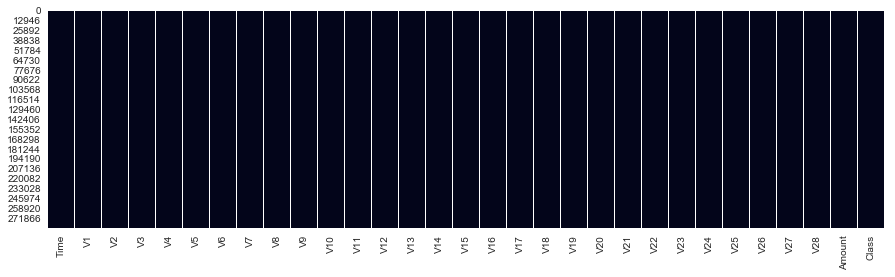

In [5]:
# Plot if any columns have missing data
plt.figure(figsize=(15,4))
sns.heatmap(data.isnull(), cbar = False)
plt.show()

It looks like our dataset does not contain any null cells!<br><br>

Now let's plot some of the data. Let's see how our dataset is split between fraudulent and authentic transactions.

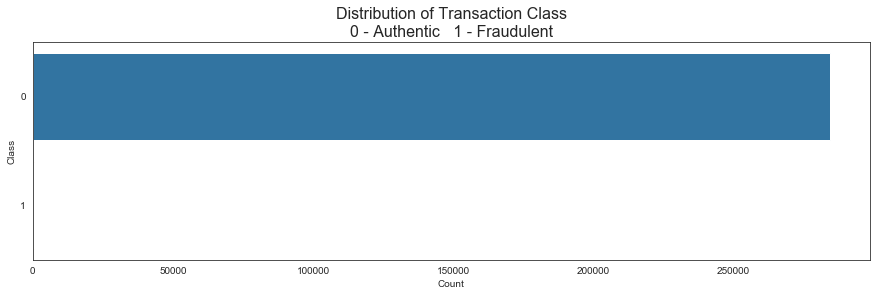

In [6]:
plt.figure(figsize=(15, 4))
sns.countplot(y = 'Class', data = data)
plt.xlabel('Count')
plt.title('Distribution of Transaction Class\n0 - Authentic   1 - Fraudulent', fontsize = 16)
plt.show()

Wow. The ratio is so small that the fraudulent transactions bar cannot even be seen in the plot above!<br><br>

Let's find out the exact numbers of authentic vs. fraudulent.

In [7]:
tcount = len(data.Class)
fraudcount0 = data['Class'].value_counts()[0]
fraudcount1 = data['Class'].value_counts()[1]
fraudpct0 = round((fraudcount0 / tcount) * 100, 2)
fraudpct1 = round((fraudcount1 / tcount) * 100, 2)

print('Total Transactions: ', tcount)
print('\n--- Class Counts ---')
print('Authentic:  ', fraudcount0)
print('Fraudulent: ', fraudcount1)
print('\n--- Class Ratios ---')
print('Authentic: ', fraudpct0, '%')
print('Fraudulent: ', fraudpct1, '%')

Total Transactions:  284807

--- Class Counts ---
Authentic:   284315
Fraudulent:  492

--- Class Ratios ---
Authentic:  99.83 %
Fraudulent:  0.17 %


## 2) Prepare Data and Run the Model

First let's split the data to define our target feature and our predictor features. Next, we will split the data into a training set and a test set, offsetting 10% of the data for testing. Then, using Gradient Boost, we will run our data through 500 iterations of random forests to hone our model, and we will display the Error rates for each set.

In [8]:
# Define outcome and predictors

y = data['Class']
X = data.drop(['Class'], axis = 1)

# Create trainng and test sets
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set
X_train, y_train = X[ : offset], y[ : offset]

# Put the remaining 10% in the test set
X_test, y_test = X[offset : ], y[offset : ]

In [9]:
# We'll make 500 iterations, use trees that are 2 branches deep, and set our loss function
params = {'n_estimators': 500, 'max_depth': 2, 'loss':'deviance'}

# Initialize and fit the model
clf = ensemble.GradientBoostingClassifier(** params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables
table_train = pd.crosstab(y_train, predict_train, margins = True)
table_test  = pd.crosstab(y_test,  predict_test,  margins = True)

train_tI_errors  = table_train.loc[0.0, 1.0] / table_train.loc['All', 'All']
train_tII_errors = table_train.loc[1.0, 0.0] / table_train.loc['All', 'All']

test_tI_errors  = table_test.loc[0.0, 1.0] / table_test.loc['All', 'All']
test_tII_errors = table_test.loc[1.0, 0.0] / table_test.loc['All', 'All']

print(('--- TRAINING SET ACCURACY ---\n'
      'Percent Type I  Errors: {}%\n'
      'Percent Type II Errors: {}%\n'
      '\n'
      '----- TEST SET ACCURACY -----\n'
      'Percent Type I  Errors: {}%\n'
      'Percent Type II Errors: {}%')
     .format((train_tI_errors  * 100).round(2),
             (train_tII_errors * 100).round(2),
             (test_tI_errors   * 100).round(2),
             (test_tII_errors  * 100).round(2)))

--- TRAINING SET ACCURACY ---
Percent Type I  Errors: 0.0%
Percent Type II Errors: 0.02%

----- TEST SET ACCURACY -----
Percent Type I  Errors: 0.01%
Percent Type II Errors: 0.03%


Those accuracy rates look pretty strong. Let's see how well it did overall.

## 3) Results and Accuracy

In [10]:
print('--------- RESULTS ---------')
print()
print('R-Squared')
print(clf.score(X_test, y_test))
print()
print('Confusion Matrix')
print(confusion_matrix(y_test, predict_test))
print()
print('Classification Report')
print(classification_report(y_test, predict_test))

--------- RESULTS ---------

R-Squared
0.9995435553526912

Confusion Matrix
[[28455     4]
 [    9    13]]

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28459
           1       0.76      0.59      0.67        22

   micro avg       1.00      1.00      1.00     28481
   macro avg       0.88      0.80      0.83     28481
weighted avg       1.00      1.00      1.00     28481



Now let's try running some cross-validation on our two datasets, Train and Test, to see if those accuracy rates are unique to this one test or if they would stay somewhere uniform across multiple subsets of the data.

In [12]:
cvs = cross_val_score(clf, X_train, y_train, cv = 5)
print('Training Set Cross Validation Values')
print(cvs)

Cross Validation Values
[0.99881013 0.99943431 0.99826392 0.99927826 0.99836146]


In [14]:
cvs_train_min = cvs.min()
cvs_train_max = cvs.max()
cvs_train_range = cvs_train_max - cvs_train_min
print('Training Set Cross-Validation Range')
print(cvs_train_range)

Training Set Cross-Validation Range
0.001170389154393825


In [13]:
cvs_test = cross_val_score(clf, X_test, y_test, cv = 5)
print('Test Set Cross-Validation Values')
print(cvs_test)

Test Set Cross-Validation Values
[0.99912235 0.99964894 0.99929775 0.99877107 0.99912204]


In [15]:
cvs_test_min = cvs_test.min()
cvs_test_max = cvs_test.max()
cvs_test_range = cvs_test_max - cvs_test_min
print('Training Set Cross-Validation Range')
print(cvs_test_range)

Training Set Cross-Validation Range
0.0008778706218333099


## 4) Summary

Our cross-validation results seem to confirm the accuracy of our model showing that all iterations range within four decimal places of each other. This model seems to be pretty strong!